나의 첫 번째 캐글 경진대회, 무작정 따라해보기
=====

- 필요한 라이브러리 import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns



- 데이터를 가져옵니다

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- date의 값을 전처리 해주기 위해 int 정수형 데이터로 처리

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
#price,id 칼럼 삭제
y = train['price'] 
del train['price']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
#test 데이터에도 적용, test데이터에는 price가 없으니 id만 진행
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


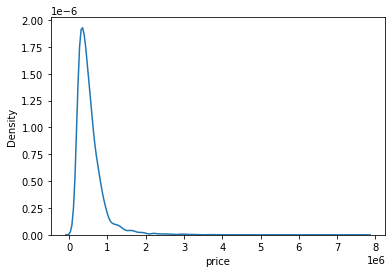

In [7]:
#타겟데이터인 y의 분포도 확인
sns.kdeplot(y)
plt.show()

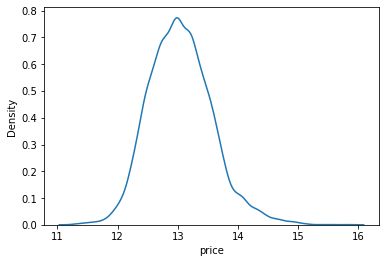

In [8]:
#log 변환을 통해 정규분포 형태로 변환
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

- 모델튜닝

- 데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위한 train_test_split 함수와,<br/> RMSE 점수를 계산하기 위한 mean_squared_error를 가져옵니다

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [10]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))#앞에서 np.log1p()로 변환했기 때문에 np.expm1()를 추가

In [11]:
#블렌딩 모델 소환
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [12]:
random_state=2020 # None으로 줄 경우 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에
                  # 파라미터 초기화나 데이터셋 구성양상이 달라져서 모델과 데이터셋이 같더라도 학습결과가 매번 달라진다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest] #모델 인스턴스 생성 후 models 리스트에 넣는다.

In [13]:
#4가지 모델의 RMSE값을 구해보자
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [14]:
#get_scores 함수에 저장
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [15]:
#GridSearchCV 활용
from sklearn.model_selection import GridSearchCV

In [16]:
#param_grid에 탐색할 xgboost 하이퍼 파라미터
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [17]:
#LightGBM 모델 사용
model = LGBMRegressor(random_state=random_state)

In [18]:
#param_grid를 활용하여 실험해보자 
grid_model = GridSearchCV(model, param_grid=param_grid, \
                          #param_grid에 n_estimators,max_depth를 넣었으므로 4가지
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5) #cross validation 5회

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [19]:
# 실험결과
grid_model.cv_results_
params = grid_model.cv_results_['params']
params
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [20]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


- GridSearchCV에서 모델을 초기화할 때 scoring<br/>MSE에 음수를 취한 값인 neg_mean_squared_error를 입력했으므로 음수로 나온다<br/>-1을 곱해주고 np.sqrt 루트 연산을 해주자

In [21]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


- 그리드 탐색을 하면서 log 값을 np.expm1() 변환 하는 과적이 없었으므로<br/>RMSLE(Root Mean Squared Log Error)로 이름 수정 *log를 취한 값에서 RMSE를 구했다는 뜻

In [22]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values('RMSLE') # 낮은순서대로 정렬
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


- 이 과정들을 my_GridSearch로 구성해보자.

In [23]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

- my_GridSearch 그리드 탐색 진행

In [24]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    2.1s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


- 가장 좋은 조합인 max_depth=10, n_estimators=100으로 학습

In [25]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [26]:
#np.expm1()로 원래 스케일
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [27]:
#sample_submission.csv 가져오자 
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [28]:
#덮어씌우자
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [29]:
#저장
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


- 이 과정들을 함수로 요약해보자

In [32]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [34]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0164399')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0164399.csv saved!


- kaggle에 올리니 115688점이 나온다.<br/> 11만점 이하로 도전

In [36]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    7.8s finished


,max_depth,n_estimators,score,RMSLE
1,10,200,-0.026188,0.161828
5,20,200,-0.026245,0.162003
3,15,200,-0.026364,0.162371
0,10,100,-0.027027,0.164399
4,20,100,-0.027051,0.164472
2,15,100,-0.027174,0.164845


- RMSLE 값이 0.161828이 나왔다 저장해보자

In [37]:
model = LGBMRegressor(max_depth=10, n_estimators=200, random_state=random_state)

In [38]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161828')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161828.csv saved!


- 115201 점 나온다...<br/> 될때까지 다 해보자

In [45]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [5, 10, 15, 20, 25, 30, 35],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 385 out of 385 | elapsed:  4.5min finished


,max_depth,n_estimators,score,RMSLE
69,35,300,-0.026091,0.161527
47,25,300,-0.026091,0.161527
36,20,300,-0.026091,0.161527
58,30,300,-0.026091,0.161527
15,10,400,-0.026121,0.161619
...,...,...,...,...
55,30,50,-0.029198,0.170875
66,35,50,-0.029198,0.170875
44,25,50,-0.029198,0.170875
33,20,50,-0.029198,0.170875


In [46]:
model = LGBMRegressor(max_depth=35, n_estimators=300, random_state=random_state)

In [47]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161527')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161527.csv saved!


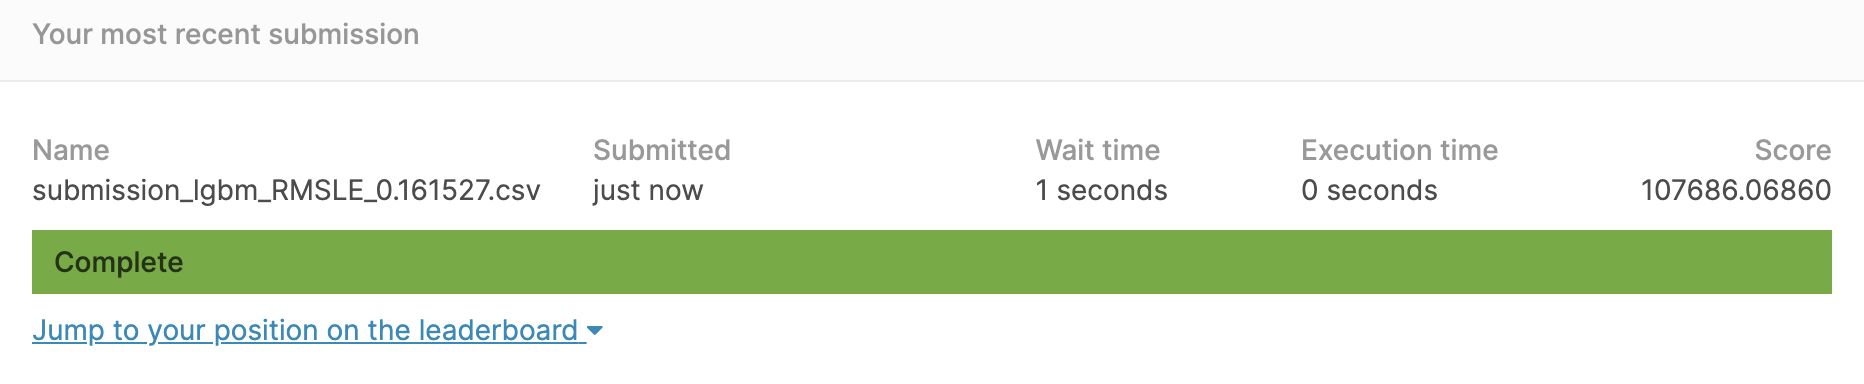

회고
-----

- n_estimators, max_depth를 많이 바꿔서 해봤는데 일정 수치 이후로는 rmsle 0.161527 이 최대였다.<br/> 파라미터가 100개 이상 된다는데 내가 사용한 파라미터는 베이직한 파라미터로 사료된다.

- 랭킹 사이트 보니 1위가 24점(?) 이던데 대체 어떻게 넣으면 그 수치가 나오는건지... 좀더 찾아봐야할거같다.(점수가 탐난다)

- 여러번 시도해야하기에 함수에 과정을 요약해서 하는 과정이 없었으면 상당히 번거로웠을듯 하다.<br/>다른 노드도 따라가면서 쭉 써놓는 경우가 많았는데 요약해서 주석을 다는 방식을 자주 사용해야겠다.<br/>추후에 다시 공부할때도 한 눈에 들어와서 이해하기 쉬울듯 하다.

- LightGBM의 장점을 좀 찾아보았는데,<br/> XGBoost 보다 빠르고 메모리 사용량도 상대적으로 적으며 말그대로 'Light'라 한다.<br/> GPU 학습을 지원하기 때문에 데이터 사이언티스트가 데이터 분석 어플을 개발할때 폭넓게 사용한다 한다.